In [1]:
import re, random, pickle, gc, os
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from pathlib import Path
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
## Sklearn package
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error 
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 99

## EDA

In [2]:
train_logs = pd.read_csv("data/raw/train_logs.csv")
target = pd.read_csv("data/raw/train_scores.csv")
train_df = train_logs.merge(target, on='id', how='inner')

In [3]:
train_df.shape

(8405898, 12)

train_df.head()

In [4]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   event_id         int64  
 2   down_time        int64  
 3   up_time          int64  
 4   action_time      int64  
 5   activity         object 
 6   down_event       object 
 7   up_event         object 
 8   text_change      object 
 9   cursor_position  int64  
 10  word_count       int64  
 11  score            float64
dtypes: float64(1), int64(6), object(5)
memory usage: 769.6+ MB


,event_id,down_time,up_time,action_time,cursor_position,word_count,score
count,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06
mean,2.067649e+03,7.935603e+05,7.936584e+05,9.808498e+01,1.222964e+03,2.314687e+02,3.992162e+00
std,1.588284e+03,5.149451e+05,5.149428e+05,2.533985e+02,9.485242e+02,1.759088e+02,9.918788e-01
min,1.000000e+00,1.060000e+02,2.520000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01
25%,8.520000e+02,3.731842e+05,3.732820e+05,6.600000e+01,4.990000e+02,9.600000e+01,3.500000e+00
50%,1.726000e+03,7.208860e+05,7.209800e+05,9.300000e+01,1.043000e+03,2.000000e+02,4.000000e+00
75%,2.926000e+03,1.163042e+06,1.163141e+06,1.220000e+02,1.706000e+03,3.270000e+02,4.500000e+00
max,1.287600e+04,8.313630e+06,8.313707e+06,4.474700e+05,7.802000e+03,1.326000e+03,6.000000e+00


In [5]:
score_counts = train_df['score'].value_counts().reset_index()
score_counts.columns = ['score', 'count'] 

chart = alt.Chart(score_counts).mark_bar().encode(
    x=alt.X('score:O', axis=alt.Axis(title='Score')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    color=alt.Color('score:N', 
                    scale=alt.Scale(scheme='tableau20'),
                    legend=alt.Legend(title="Score Values"))
)

chart  

alt.Chart(...)

In [6]:
average_events_train = train_df.groupby("id").count()["event_id"].mean().round(0)
print(f'The average number of events per essay in the train dataset is: {average_events_train}')

train_event_counts = train_df.groupby('id')['event_id'].count().reset_index()
train_event_counts.columns = ['id', 'event_count']

train_chart = alt.Chart(train_event_counts).mark_bar().encode(
    alt.X("event_count:Q", bin=alt.Bin(maxbins=30), title="Number of Events"),
    alt.Y('count()', title="Number of Essays"),
    tooltip=[alt.Tooltip('count()', title='Number of Essays'), alt.Tooltip('event_count', title='Events')]
).properties(
    title="Distribution of the Number of Events per Essay - Train Dataset"
)

train_chart.display()

The average number of events per essay in the train dataset is: 3402.0


alt.Chart(...)

In [7]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64'])

spearman_corr_matrix = numerical_columns.corr(method='spearman').reset_index()

# Melt the correlation matrix into a long-form DataFrame
corr_df_long = spearman_corr_matrix.melt('index')

# Create the heatmap in Altair
heatmap = alt.Chart(corr_df_long).mark_rect().encode(
    x=alt.X('index:O', title=None), 
    y=alt.Y('variable:O', title=None), 
    color='value:Q', 
    tooltip=[
        alt.Tooltip('index', title='Variable 1'),
        alt.Tooltip('variable', title='Variable 2'),
        alt.Tooltip('value', title='Correlation', format=".2f")
    ]
).properties(
    title='Spearman Correlation Matrix',
    width=500,
    height=500
)

text = heatmap.mark_text(baseline='middle').encode(
    text=alt.Text('value:Q', format='.2f'),
    color=alt.condition(
        alt.datum.value > 0.5,
        alt.value('white'),
        alt.value('black')
    )
)

final_chart = heatmap + text

final_chart.display()

alt.LayerChart(...)

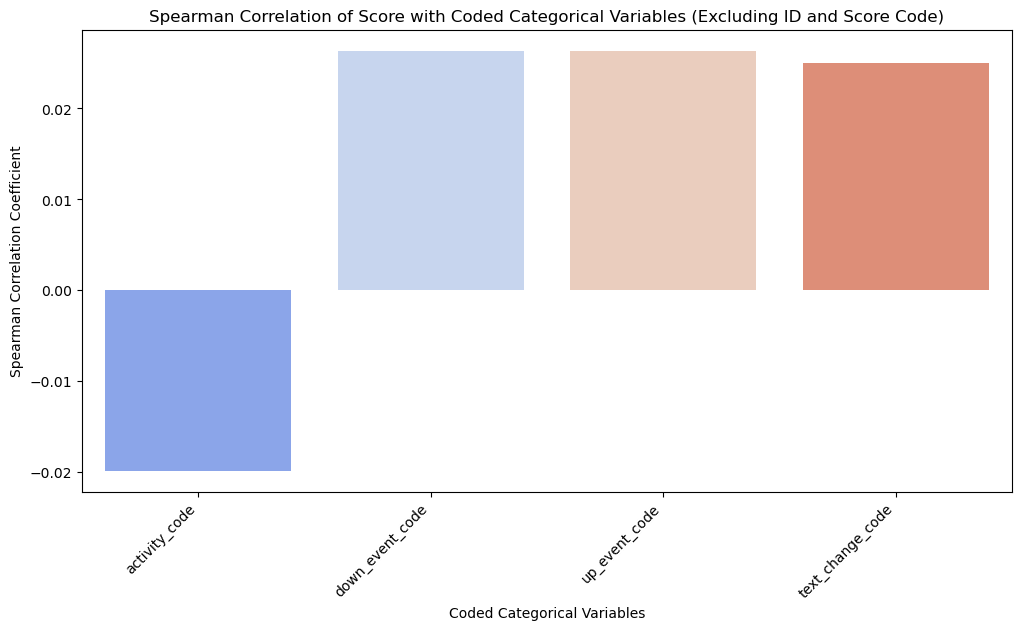

In [8]:
category_columns = train_df.select_dtypes(include=['object']).drop('id', axis=1)

for col in category_columns:
    train_df[col + '_code'] = train_df[col].astype('category').cat.codes

coded_category_columns = train_df.filter(regex='_code$')
coded_category_columns = coded_category_columns.drop(['id_code', 'score_code'], axis=1, errors='ignore')  

spearman_corr_coded_category = coded_category_columns.corrwith(train_df['score'], method='spearman')

plt.figure(figsize=(12, 6))
sns.barplot(x=spearman_corr_coded_category.index, y=spearman_corr_coded_category.values, palette='coolwarm', dodge=False)
plt.title('Spearman Correlation of Score with Coded Categorical Variables (Excluding ID and Score Code)')
plt.xlabel('Coded Categorical Variables')
plt.ylabel('Spearman Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

## Generate Features from train logs

In [9]:
train_logs = pl.scan_csv("data/raw/train_logs.csv")
display(train_logs.collect().head())

id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
str,i64,i64,i64,i64,str,str,str,str,i64,i64
"""001519c8""",1,4526,4557,31,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0
"""001519c8""",2,4558,4962,404,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0
"""001519c8""",3,106571,106571,0,"""Nonproduction""","""Shift""","""Shift""","""NoChange""",0,0
"""001519c8""",4,106686,106777,91,"""Input""","""q""","""q""","""q""",1,1
"""001519c8""",5,107196,107323,127,"""Input""","""q""","""q""","""q""",2,1


In [10]:
class FeatureExtractor():
    def __init__(self, logs):
        self.logs = logs # Training logs
        
    def count_by_values(self, colname, used_cols):
        fts = self.logs.select(pl.col('id').unique(maintain_order=True))
        for i, col in enumerate(used_cols):
            tmp_logs = self.logs.group_by('id').agg(
                            pl.col(colname).is_in([col]).sum().alias(f'{colname}_{i}_cnt')
                                    )
            fts  = fts.join(tmp_logs, on='id', how='left') 
        return fts
    
    def create_count_by_values_feats(self):
        activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.',
                       ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']        
        #=== Create the feature columns using count by values ===
        df = self.count_by_values('activity', activities) # Create 'activity' column
        df = df.join(self.count_by_values('text_change', text_changes), on='id', how='left') 
        df = df.join(self.count_by_values('down_event', events), on='id', how='left') 
        df = df.join(self.count_by_values('up_event', events), on='id', how='left')
        # print(df.collect().head())
        return df

    # Create the features 
    def create_input_words_feats(self):
        # Filter no changes 
        df = self.logs.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
        # Aggregate the text changes by id
        df = df.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
        # creates only two columns ('id' and 'text_change') 
        df = df.with_columns(input_word_count=pl.col('text_change').list.lengths(),
                             input_word_length_mean=pl.col('text_change').apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max=pl.col('text_change').apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std=pl.col('text_change').apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median=pl.col('text_change').apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew=pl.col('text_change').apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
        df = df.drop('text_change') # Remove 'text_change' to avoid including duplicated `text_change` column
        return df
    
    # Create the statistical numeric features (e.g. sum, median, mean min, 0.5_quantile)
    def create_numeric_feats(self):
        num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
        df = self.logs.group_by("id").agg(pl.sum('action_time').suffix('_sum'),
                                                pl.mean(num_cols).suffix('_mean'),
                                                pl.std(num_cols).suffix('_std'),
                                                pl.median(num_cols).suffix('_median'), pl.min(num_cols).suffix('_min'), pl.max(num_cols).suffix('_max'),
                                                pl.quantile(num_cols, 0.5).suffix('_quantile'))
        return df
    
    def create_categorical_feats(self):
        df  = self.logs.group_by("id").agg(
                pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
        return df
    
    # Create the idle time features 
    def create_idle_time_feats(self):
        df = self.logs.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
        df = df.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
        df = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
        df = df.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') < 3)).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
        return df
    
    # Create p-bursts features using up and down time and activity
    def create_p_bursts_feats(self):
        df = self.logs.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
        df = df.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
        df = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
        df = df.with_columns(pl.col('time_diff')<2)
        df = df.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
        df = df.drop_nulls()
        df = df.group_by("id").agg(pl.mean('P-bursts').suffix('_mean'),
                                   pl.std('P-bursts').suffix('_std'),
                                   pl.count('P-bursts').suffix('_count'),
                                   pl.median('P-bursts').suffix('_median'),
                                   pl.max('P-bursts').suffix('_max'),
                                   pl.first('P-bursts').suffix('_first'),
                                   pl.last('P-bursts').suffix('_last'))
        return df
    
    # Create r-burst features using activity 
    def create_r_bursts_feats(self):
        df = self.logs.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
        df = df.with_columns(pl.col('activity').is_in(['Remove/Cut']))
        df = df.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
        df = df.drop_nulls()
        df = df.group_by("id").agg(pl.mean('R-bursts').suffix('_mean'),
                                   pl.std('R-bursts').suffix('_std'), 
                                   pl.median('R-bursts').suffix('_median'),
                                   pl.max('R-bursts').suffix('_max'),
                                   pl.first('R-bursts').suffix('_first'),
                                   pl.last('R-bursts').suffix('_last'))
        return df
    
    # Main function creates all 122 features
    def create_feats(self):
        feats = self.create_count_by_values_feats()  # 52 columns in total
#         print(f"< Count by values features > {len(feats.columns)}")        
        feats = feats.join(self.create_input_words_feats(), on='id', how='left')  # 58 columns
#         print(f"< Input words stats features > {len(feats.columns)}")
        feats = feats.join(self.create_numeric_feats(), on='id', how='left') # 89 columns
#         print(f"< Numerical features > {len(feats.columns)}")
        feats = feats.join(self.create_categorical_feats(), on='id', how='left') # 93 columns      
#         print(f"< Categorical features > {len(feats.columns)}")
        feats = feats.join(self.create_idle_time_feats(), on='id', how='left') # 103 columns
#         print(f"< Idle time features > {len(feats.columns)}")
        feats = feats.join(self.create_p_bursts_feats(), on='id', how='left') # 110 columns
#         print(f"< P-bursts features > {len(feats.columns)}")
        feats = feats.join(self.create_r_bursts_feats() , on='id', how='left') # 116 columns
#         print(f"< R-bursts features > {len(feats.columns)}")        
        return feats # 116 features 

In [11]:
fe = FeatureExtractor(train_logs)
train_feats = fe.create_feats() # Extract features from trainning logs (polars df)
train_feats = train_feats.collect().to_pandas() # Convert polars df to pandas df
train_feats.to_csv("train_feats_0.csv")
# print(train_feats.describe())
train_logs = train_logs.collect().to_pandas()  # Convert polars df to pandas df
del fe

In [12]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

class EssayConstructor():
    def __init__(self, logs):
        self.logs = logs
        self.train_essays = self.get_train_essays(self.logs)
        self.AGGREGATIONS = ['count', 'mean', 'min', 'max', 'first', 'last', q1, 'median', q3, 'sum']
    
    # Get the essay from train logs 
    def get_train_essays(self, logs):
        def reconstruct_essay(currTextInput):
            essayText = ""
            for Input in currTextInput.values:
                if Input[0] == 'Replace':
                    replaceTxt = Input[2].split(' => ')
                    essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                    continue
                if Input[0] == 'Paste':
                    essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                    continue
                if Input[0] == 'Remove/Cut':
                    essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                    continue
                if "M" in Input[0]:
                    croppedTxt = Input[0][10:]
                    splitTxt = croppedTxt.split(' To ')
                    valueArr = [item.split(', ') for item in splitTxt]
                    moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
                    if moveData[0] != moveData[2]:
                        if moveData[0] < moveData[2]:
                            essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                        else:
                            essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                    continue
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            return essayText
        
        # Filter logs 
        df = logs[logs.activity != 'Nonproduction']
        group_df = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
        essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
        essay_df = essay_df.merge(group_df.rename('essay'), on='id')
        return essay_df

    # Create word level features from train essay
    def create_word_feats(self):
        df = self.train_essays.copy()
        df['word'] = df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
        df = df.explode('word')
        df['word_len'] = df['word'].apply(lambda x: len(x))
        df = df[df['word_len'] != 0] # Remove all the no-word record
        # Aggregate word level features
        word_agg_df = df[['id','word_len']].groupby(['id']).agg(self.AGGREGATIONS)
        word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
        word_agg_df['id'] = word_agg_df.index
        word_agg_df = word_agg_df.reset_index(drop=True)
        return word_agg_df
    # Create sentence level features
    def create_sentence_feats(self):
        df = self.train_essays.copy()
        df['sent'] = df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
        df = df.explode('sent')
        df['sent'] = df['sent'].apply(lambda x: x.replace('\n','').strip())
        # Number of characters in sentences
        df['sent_len'] = df['sent'].apply(lambda x: len(x))
        # Number of words in sentences
        df['sent_word_count'] = df['sent'].apply(lambda x: len(x.split(' ')))
        df = df[df.sent_len!=0].reset_index(drop=True)
        # Aggregate sentence level features
        sent_agg_df = pd.concat([df[['id','sent_len']].groupby(['id']).agg(self.AGGREGATIONS), 
                                 df[['id','sent_word_count']].groupby(['id']).agg(self.AGGREGATIONS)], axis=1)
        sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
        sent_agg_df['id'] = sent_agg_df.index
        sent_agg_df = sent_agg_df.reset_index(drop=True)
        sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
        sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
        return sent_agg_df
    # Create paragraph level features
    def create_paragraph_feats(self):
        df = self.train_essays.copy()
        df['paragraph'] = df['essay'].apply(lambda x: x.split('\n'))
        df = df.explode('paragraph')
        # Number of characters in paragraphs
        df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x)) 
        # Number of words in paragraphs
        df['paragraph_word_count'] = df['paragraph'].apply(lambda x: len(x.split(' ')))
        df = df[df.paragraph_len!=0].reset_index(drop=True)
        # Aggregate paragraph level features
        paragraph_agg_df = pd.concat([df[['id','paragraph_len']].groupby(['id']).agg(self.AGGREGATIONS), 
                                      df[['id','paragraph_word_count']].groupby(['id']).agg(self.AGGREGATIONS)], axis=1) 
        paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
        paragraph_agg_df['id'] = paragraph_agg_df.index
        paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
        paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
        paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
        return paragraph_agg_df

    
    # Create product to keys features
    def create_product_to_keys_feats(self):
        essays = self.train_essays.copy()
        logs = self.logs.copy()
        essays['product_len'] = essays['essay'].str.len()
        tmp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg({'activity': 'count'}).reset_index().rename(columns={'activity': 'keys_pressed'})
        essays = essays.merge(tmp_df, on='id', how='left')
        essays['product_to_keys'] = essays['product_len'] / essays['keys_pressed']
        return essays[['id', 'product_to_keys']]

    # Create key pressed features
    def create_keys_pressed_feats(self):
        logs = self.logs.copy()
        temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
        temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
        temp_df = temp_df.merge(temp_df_2, on='id', how='left')
        temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
        return temp_df[['id', 'keys_per_second']]
    
    def create_feats(self, feats):
        feats = feats.merge(self.create_word_feats(), on='id', how='left') # 126 columns in total
#         print(f"{len(feats.columns)}")
        feats = feats.merge(self.create_sentence_feats(), on='id', how='left') # 145 columns
#         print(f"{len(feats.columns)}")
        feats = feats.merge(self.create_paragraph_feats(), on='id', how='left') # 164 columns
#         print(f"{len(feats.columns)}")
        feats = feats.merge(self.create_keys_pressed_feats(), on='id', how='left') # 166 columns
#         print(f"{len(feats.columns)}")
        feats = feats.merge(self.create_product_to_keys_feats(), on='id', how='left') # 165 columns
#         print(f"{len(feats.columns)}")
        return feats

In [13]:
print('< Essay Reconstruction >')
ec = EssayConstructor(train_logs)
train_feats = ec.create_feats(train_feats)
# Writing to csg
train_feats.to_csv("train_feats.csv")
del ec

< Essay Reconstruction >


## Train and test set spliting

In [14]:
target = pd.read_csv("data/raw/train_scores.csv")
df = train_feats.merge(target, on='id', how='left')
df.shape

(2471, 167)

In [15]:
df.head()

,id,activity_0_cnt,activity_1_cnt,activity_2_cnt,activity_3_cnt,activity_4_cnt,text_change_0_cnt,text_change_1_cnt,text_change_2_cnt,text_change_3_cnt,...,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_sum,keys_per_second,product_to_keys,score
0,001519c8,2010,417,120,7,0,1940,436,28,14,...,112,71,86,78.50,86.0,99.00,269,1.350251,0.629584,3.5
1,0022f953,1938,260,254,1,1,1698,432,18,24,...,96,53,60,47.75,56.5,62.25,355,1.250038,0.762056,3.5
2,0042269b,3515,439,175,7,0,3257,615,23,26,...,88,79,45,55.50,73.5,78.75,410,2.237402,0.654274,6.0
3,0059420b,1304,151,99,1,1,1146,281,13,3,...,81,62,65,63.50,65.0,73.00,208,1.067440,0.793127,2.0
4,0075873a,1942,517,72,0,0,1964,397,32,25,...,114,61,3,26.00,52.0,61.00,256,1.552397,0.579504,4.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Columns: 167 entries, id to score
dtypes: float64(61), int64(40), object(1), uint32(65)
memory usage: 2.5+ MB


In [17]:
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.shape

(1729, 167)

In [18]:
valid_df.shape

(742, 167)

In [19]:
# drop the unique identifier and the target
X_train, y_train = (
    train_df.drop(columns=["id","score"], axis=1),
    train_df["score"].values,
)

X_valid, y_valid = (
    valid_df.drop(columns=["id","score"], axis=1),
    valid_df["score"].values,
)

## Train Different Models

In [20]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

In [21]:
# Define score metric: RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring_metric = make_scorer(rmse)

In [22]:
# Baseline model
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

dummy = DummyRegressor(strategy="mean")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),1.036 (+/- 0.043),1.034 (+/- 0.011)


In [23]:
# Different models
models = {
    "lasso": Lasso(alpha=1.0, random_state=123),
    "Ridge": Ridge(alpha=1.0, random_state=123),
    "random forest": RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                                           min_samples_leaf=1, max_features='sqrt', bootstrap=True, random_state=123),
    "lgbm": LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=123, verbose=-1),
    "xgb": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=123, verbosity=0),
    "CatBoost": CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, random_state=123, verbose=0),
    "SVR": SVR(C=1.0, kernel='rbf', gamma='scale', epsilon=0.1)
}

for name, model in models.items():
    pipe = make_pipeline(
    FunctionTransformer(lambda x: np.nan_to_num(x, nan=np.nan, posinf=0, neginf=0)),
    SimpleImputer(strategy='mean'),
    FunctionTransformer(lambda x: np.log1p(np.abs(x))),
    RobustScaler(),
    model)
    
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),1.036 (+/- 0.043),1.034 (+/- 0.011)
lasso,0.020 (+/- 0.002),0.001 (+/- 0.000),1.036 (+/- 0.043),1.034 (+/- 0.011)
Ridge,0.025 (+/- 0.004),0.001 (+/- 0.000),0.654 (+/- 0.036),0.591 (+/- 0.009)
random forest,0.639 (+/- 0.030),0.006 (+/- 0.000),0.647 (+/- 0.043),0.242 (+/- 0.005)
lgbm,0.557 (+/- 0.055),0.003 (+/- 0.000),0.651 (+/- 0.042),0.118 (+/- 0.004)
xgb,0.230 (+/- 0.011),0.002 (+/- 0.000),0.640 (+/- 0.048),0.435 (+/- 0.011)
CatBoost,0.143 (+/- 0.036),0.002 (+/- 0.000),0.642 (+/- 0.038),0.556 (+/- 0.009)
SVR,0.112 (+/- 0.001),0.036 (+/- 0.000),0.664 (+/- 0.044),0.487 (+/- 0.012)
